# Detroit Blight Ticket Compliance

[Blight violations](http://www.detroitmi.gov/How-Do-I/Report/Blight-Complaint-FAQs) are issued by the city to individuals who allow their properties to remain in a deteriorated condition. Every year, the city of Detroit issues millions of dollars in fines to residents and every year, many of these fines remain unpaid. Enforcing unpaid blight fines is a costly and tedious process, so the city wants to know: how can we increase blight ticket compliance?

The first step in answering this question is understanding when and why a resident might fail to comply with a blight ticket. This is where predictive modeling comes in. For this assignment, your task is to predict whether a given blight ticket will be paid on time.

All data has been provided to us through the [Detroit Open Data Portal](https://data.detroitmi.gov/). We encourage you to look into data from other Detroit datasets to help inform feature creation and model selection. We recommend taking a look at the following related datasets:

* [Building Permits](https://data.detroitmi.gov/Property-Parcels/Building-Permits/xw2a-a7tf)
* [Trades Permits](https://data.detroitmi.gov/Property-Parcels/Trades-Permits/635b-dsgv)
* [Improve Detroit: Submitted Issues](https://data.detroitmi.gov/Government/Improve-Detroit-Submitted-Issues/fwz3-w3yn)
* [DPD: Citizen Complaints](https://data.detroitmi.gov/Public-Safety/DPD-Citizen-Complaints-2016/kahe-efs3)
* [Parcel Map](https://data.detroitmi.gov/Property-Parcels/Parcel-Map/fxkw-udwf)

___

We provide you with two data files for use in training and validating your models: train.csv and test.csv. Each row in these two files corresponds to a single blight ticket, and includes information about when, why, and to whom each ticket was issued. The target variable is compliance, which is True if the ticket was paid early, on time, or within one month of the hearing data, False if the ticket was paid after the hearing date or not at all, and Null if the violator was found not responsible. Compliance, as well as a handful of other variables that will not be available at test-time, are only included in train.csv.

Note: All tickets where the violators were found not responsible are not considered during evaluation. They are included in the training set as an additional source of data for visualization, and to enable unsupervised and semi-supervised approaches. However, they are not included in the test set.

<br>

**File descriptions** (Use only this data for training your model!)

    train.csv - the training set (all tickets issued 2004-2011)
    test.csv - the test set (all tickets issued 2012-2016)
    addresses.csv & latlons.csv - mapping from ticket id to addresses, and from addresses to lat/lon coordinates. 
     Note: misspelled addresses may be incorrectly geolocated.
</br>

**Data fields**

train.csv & test.csv

    ticket_id - unique identifier for tickets
    agency_name - Agency that issued the ticket
    inspector_name - Name of inspector that issued the ticket
    violator_name - Name of the person/organization that the ticket was issued to
    violation_street_number, violation_street_name, violation_zip_code - Address where the violation occurred
    mailing_address_str_number, mailing_address_str_name, city, state, zip_code, non_us_str_code, country - Mailing address of the violator
    ticket_issued_date - Date and time the ticket was issued
    hearing_date - Date and time the violator's hearing was scheduled
    violation_code, violation_description - Type of violation
    disposition - Judgment and judgement type
    fine_amount - Violation fine amount, excluding fees
    admin_fee - $20 fee assigned to responsible judgments
state_fee - $10 fee assigned to responsible judgments
    late_fee - 10% fee assigned to responsible judgments
    discount_amount - discount applied, if any
    clean_up_cost - DPW clean-up or graffiti removal cost
    judgment_amount - Sum of all fines and fees
    grafitti_status - Flag for graffiti violations
    
train.csv only

    payment_amount - Amount paid, if any
    payment_date - Date payment was made, if it was received
    payment_status - Current payment status as of Feb 1 2017
    balance_due - Fines and fees still owed
    collection_status - Flag for payments in collections
    compliance [target variable for prediction] 
     Null = Not responsible
     0 = Responsible, non-compliant
     1 = Responsible, compliant
    compliance_detail - More information on why each ticket was marked compliant or non-compliant

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import pytest
import warnings
warnings.filterwarnings('ignore')

In [246]:
test = pd.read_csv('test.csv')

In [197]:
train = pd.read_csv('train.csv', encoding='ISO-8859-1')

### Data Preprocessing

In [178]:
def get_null_index(data_frame, feature, isTrain=True):
    """Return an array of int
    
    Any null values for country of USA
    when compaliance value not null
    """
    index_usa_only = []
    df = data_frame
    
    if isTrain:
        usa_only = df[df.compliance.notnull()].country == 'USA'
    else:
        usa_only = df.country == 'USA'
        
    index_usa_only = [index 
                      for index, val in enumerate(
                          df.loc[usa_only.index,[feature]].isnull()[feature]
                      ) if val
                     ]
    return index_usa_only

In [179]:
class TestGetNullIndex(object):
    """
    Testing get_null_index() against fine_amount feature

    """
    
    def test_no_index(self):
        answer = []
        df1 =  pd.DataFrame({'fine_amount':[100, 1, 0, 20, 100], 
                             'country':['USA', 'USA', 'USA', 'USA', 'USA'],
                             'compliance':[1, 1, 1, 1, 1]})
        
        assert get_null_index(df1, 'fine_amount') == [], "expect " + str(answer)
        
    
    def test_single_index(self):
        answer = [1]
        df2 = pd.DataFrame({'fine_amount':[100, None, 0, 20, 100],
                                'country':['USA', 'USA', 'USA', 'USA', 'USA'],
                                'compliance':[1, 1, 1, 1, 1]})
        
        assert get_null_index(df2, 'fine_amount') == answer, "expect " + str(answer)
        
    
    def test_multiple_index(self):
        answer = [0, 1, 4]
        df3 = pd.DataFrame({'fine_amount':[None, None, 0, 20, None], 
                            'country':['USA', 'USA', 'USA', 'USA', 'USA'],
                            'compliance':[1, 1, 1, 1, 1]})
        
        assert get_null_index(df3, 'fine_amount') == answer, "expect " + str(answer)

In [189]:
## Testing for null index in train dataset
_null_index_test = TestGetNullIndex()

_null_index_test.test_no_index()
_null_index_test.test_single_index()
_null_index_test.test_multiple_index()

### Check presence of null values in selected features of train and test dataset

In [187]:
# Train data
features = ['fine_amount', 'discount_amount', 'judgment_amount', 
            'admin_fee', 'state_fee', 'late_fee', 'clean_up_cost']

print("Train")
print(
    {feature: get_null_index(train, feature)
 for feature in features if get_null_index(train, feature)
}
)

print("Test")
print(
    {feature: get_null_index(test, feature, isTrain=False)
 for feature in features if get_null_index(test, feature, isTrain=False)
}
)

Train
{}
Test
{}


In [190]:
#NOTE: This confirms that there are no null values in selectd features

### Feature Importance

In [191]:
def plot_feature_importance(dataFrame=train):
    '''
     Which features are important?
    '''
    
    train = dataFrame
    features = ['fine_amount', 'discount_amount', 'judgment_amount', 
                'admin_fee', 'state_fee', 'late_fee', 'clean_up_cost']
    train_usa = train[train.compliance.notnull()][train.country=='USA']

    y = train_usa['compliance']
    X = train_usa[features]

    x_train, x_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=45)
    clf = RandomForestClassifier(random_state=0, n_estimators=10, bootstrap=False)
    clf.fit(x_train, y_train)

    importances = clf.feature_importances_
    sorted_index = np.argsort(importances)
    labels = x_train.columns[sorted_index]  
    plt.barh(range(x_train.shape[1]), importances[sorted_index], tick_label=labels)
    plt.show()

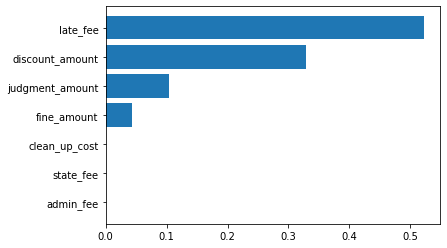

In [198]:
plot_feature_importance()

### late_fee, discount_amount, judgment_amount, fine_amount will be consider in the model
##### total = fine_amount + judgment_amount - discount_amount + late_fee

### Hyperparameter Search

In [399]:
def get_best_param(dataFrame=train):
    
    train = dataFrame
    features = ['fine_amount', 'discount_amount', 'judgment_amount', 'late_fee', 'total']
    
    train_usa = train[train['compliance'].notnull()][train.country=='USA']
    train_usa['total'] = train_usa.fine_amount \
    + train_usa.judgment_amount - train_usa.discount_amount + train_usa.late_fee
    
    y = train_usa['compliance']
    X = train_usa[features]
    
    x_train, x_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=45)

    para_grid = {'n_estimators':[10, 30, 60], 
                 'max_features':['auto'], 
                 'bootstrap':[True, False],
                 'criterion': ['gini', 'entropy']}
  
    clf = RandomizedSearchCV(RandomForestClassifier(random_state=45), para_grid)
    search = clf.fit(x_train, y_train)
    
    return search.best_params_

In [400]:
get_best_param(train)

{'n_estimators': 10,
 'max_features': 'auto',
 'criterion': 'gini',
 'bootstrap': True}

### Model

In [348]:
def blight_model(dataFrame=train):
    
    """Return model, area_under_ROC 
    
    RandomForestClassifier model returns
    probabilty of compliant (class 1)
    
    """
    
    train = dataFrame
    features = ['fine_amount', 'discount_amount', 'judgment_amount', 'late_fee', 'total']
    
    train_usa = train[train['compliance'].notnull()][train.country=='USA']
    train_usa['total'] = train_usa.fine_amount \
    + train_usa.judgment_amount - train_usa.discount_amount + train_usa.late_fee
    
    y = train_usa['compliance']
    X = train_usa[features]
    
    x_train, x_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=45)
    clf = RandomForestClassifier(random_state=0, 
                                 n_estimators=10, 
                                 max_features='auto', 
                                 criterion = 'entropy', 
                                 bootstrap=True)
    clf.fit(x_train, y_train)
    y_pred_prob = clf.predict_proba(x_test)
    
    return clf, roc_auc_score(y_test, y_pred_prob[:,1])

### Model and Evaluation

In [349]:
clf_model, auc_score = blight_model(train)

In [350]:
print(auc_score)

0.7562468460831332


### Predictions

In [6]:
def predict_prob_compliance(model, fine, discount, judgment_amount, late_fee):
    
    df = pd.DataFrame({"fine_amount":[fine], 
                      "discount_amount": [discount],
                      "judgment_amount": [judgment_amount],
                      "late_fee": [late_fee],
                      "total": [fine + judgment_amount - discount + late_fee]
                     })
    #this order of feature is very important
    df = df[['fine_amount', 'discount_amount', 'judgment_amount', 'late_fee', 'total']]
    pred_prob = model.predict_proba(df)
        
    return pred_prob[:,1][0]

### Prediction Examples from test dataset

In [390]:
test[['fine_amount', 'discount_amount', 'judgment_amount', 'late_fee']].head()

,fine_amount,discount_amount,judgment_amount,late_fee
0,200.0,0.0,250.0,20.0
1,1000.0,0.0,1130.0,100.0
2,100.0,0.0,140.0,10.0
3,200.0,0.0,250.0,20.0
4,100.0,0.0,140.0,10.0


In [391]:
predict_prob_compliance(clf_model, fine=1000.0, discount=0.0, judgment_amount=1130.0, late_fee=100.0)

0.022364511088289903

In [392]:
test[['fine_amount', 'discount_amount', 'judgment_amount', 'late_fee']].tail()

,fine_amount,discount_amount,judgment_amount,late_fee
60996,1000.0,0.0,1130.0,100.0
60997,1000.0,0.0,1130.0,100.0
60998,100.0,0.0,140.0,10.0
60999,100.0,0.0,140.0,10.0
61000,50.0,0.0,80.0,0.0


In [397]:
predict_prob_compliance(clf_model, fine=250.0, discount=0.0, judgment_amount=305.0, late_fee=25.0)

0.03603206685781632

### Preparing model for a web app

In [1]:
import pickle

In [402]:
with open('blight_ticket_violation_model.pickle', 'wb') as f:
    pickle.dump(clf_model,f)

### Using the model in pickle file for prediction

In [3]:
with open('./blight_ticket_violation_model.pickle', 'rb') as f:
    _model = pickle.load(f)

In [4]:
_model

RandomForestClassifier(criterion='entropy', n_estimators=10, random_state=0)

In [10]:
predict_prob_compliance(model=_model, 
                        fine=250.0, discount=0.0, judgment_amount=305.0, late_fee=25)

0.03603206685781632

In [ ]:
_model.predict()